### Import Libraries

In [1]:
import os
import zipfile
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

import tensorflow_hub as hub

In [13]:
import warnings
warnings.filterwarnings('ignore')

### Import Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Sesuaikan path
!unzip '/content/drive/MyDrive/Bangkit Group C22-PC385/ML/Colabs/dataset_v5.zip' > /dev/null

## Preprocess Image

### Folders path

In [4]:
train_dir = '/content/dataset_v5/training'
train_battery_dir = os.path.join(train_dir, 'battery')
train_cardboard_dir = os.path.join(train_dir, 'cardboard')
train_clothes_dir = os.path.join(train_dir, 'clothes')
train_ewaste_dir = os.path.join(train_dir, 'e-waste')
train_food_dir = os.path.join(train_dir, 'food')
train_glass_dir = os.path.join(train_dir, 'glass')
train_lightblubs_dir = os.path.join(train_dir, 'light-bulbs')
train_metal_dir = os.path.join(train_dir, 'metal')
train_paper_dir = os.path.join(train_dir, 'paper')
train_plastic_dir = os.path.join(train_dir, 'plastic')
train_shoes_dir = os.path.join(train_dir, 'shoes')

validation_dir = '/content/dataset_v5/validation'
validation_battery_dir = os.path.join(validation_dir, 'battery')
validation_cardboard_dir = os.path.join(validation_dir, 'cardboard')
validation_clothes_dir = os.path.join(validation_dir, 'clothes')
validation_ewaste_dir = os.path.join(validation_dir, 'e-waste')
validation_food_dir = os.path.join(validation_dir, 'food')
validation_glass_dir = os.path.join(validation_dir, 'glass')
validation_lightblubs_dir = os.path.join(validation_dir, 'light-bulbs')
validation_metal_dir = os.path.join(validation_dir, 'metal')
validation_paper_dir = os.path.join(validation_dir, 'paper')
validation_plastic_dir = os.path.join(validation_dir, 'plastic')
validation_shoes_dir = os.path.join(validation_dir, 'shoes')

test_dir = '/content/dataset_v5/testing'
test_battery_dir = os.path.join(test_dir, 'battery')
test_cardboard_dir = os.path.join(test_dir, 'cardboard')
test_clothes_dir = os.path.join(test_dir, 'clothes')
test_ewaste_dir = os.path.join(test_dir, 'e-waste')
test_food_dir = os.path.join(test_dir, 'food')
test_glass_dir = os.path.join(test_dir, 'glass')
test_lightblubs_dir = os.path.join(test_dir, 'light-bulbs')
test_metal_dir = os.path.join(test_dir, 'metal')
test_paper_dir = os.path.join(test_dir, 'paper')
test_plastic_dir = os.path.join(test_dir, 'plastic')
test_shoes_dir = os.path.join(test_dir, 'shoes')

### Show example images

Sample battery image:


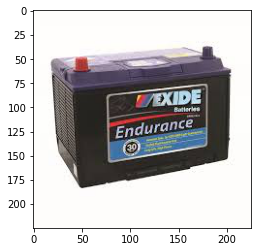


Sample paper image:


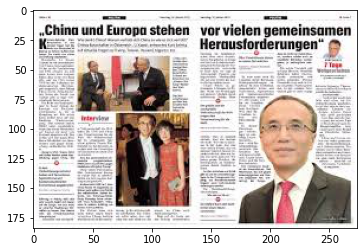

In [ ]:
print("Sample battery image:")
plt.imshow(load_img(f"{os.path.join(train_battery_dir, os.listdir(train_battery_dir)[1])}"))
plt.show()

print("\nSample paper image:")
plt.imshow(load_img(f"{os.path.join(train_paper_dir, os.listdir(train_paper_dir)[2])}"))
plt.show()

### ImageDataGenerator

In [5]:
batch_size = 32

def train_val_generators(TRAINING_DIR, VALIDATION_DIR, TESTING_DIR):
  
  train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     vertical_flip=True)

  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=batch_size, 
                                                      class_mode='sparse',
                                                      target_size=(224, 224))

  validation_datagen = ImageDataGenerator(rescale=1./255)

  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=batch_size, 
                                                                class_mode='sparse',
                                                                target_size=(224, 224))
  
  testing_datagen = ImageDataGenerator(rescale=1./255)

  testing_generator = testing_datagen.flow_from_directory(directory=TESTING_DIR,
                                                                class_mode='sparse',
                                                                batch_size=batch_size,
                                                                target_size=(224, 224))
  ### END CODE HERE
  return train_generator, validation_generator, testing_generator

In [6]:
training_generator, validation_generator, testing_generator = train_val_generators(train_dir, validation_dir, test_dir)

Found 5814 images belonging to 11 classes.
Found 1045 images belonging to 11 classes.
Found 758 images belonging to 11 classes.


In [8]:
class_dict = testing_generator.class_indices
class_dict = dict([(value, key) for key, value in class_dict.items()])
class_dict

{0: 'battery',
 1: 'cardboard',
 2: 'clothes',
 3: 'e-waste',
 4: 'food',
 5: 'glass',
 6: 'light bulbs',
 7: 'metal',
 8: 'paper',
 9: 'plastic',
 10: 'shoes'}

e-waste


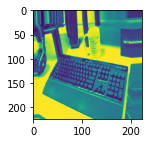

paper


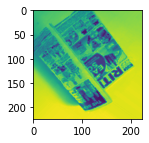

plastic


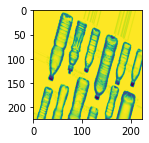

shoes


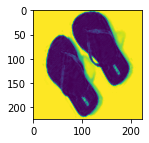

shoes


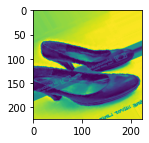

cardboard


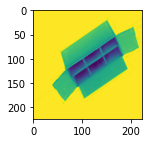

food


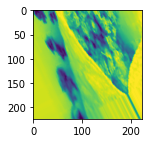

glass


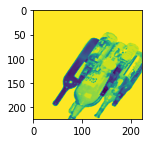

glass


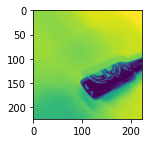

clothes


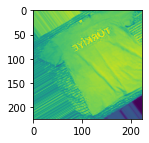

In [9]:
import matplotlib.pyplot as plt
import os
n = 10
image, label = training_generator.next()
for i in range(0,n):
    plt.figure(figsize=(2, 2))
    image_x = image[i,:,:,0]
    image_label = class_dict[label[i]]
    print(image_label)
    plt.imshow(image_x)
    plt.show()

## Build the model

### Import InceptionV3

In [10]:
IMAGE_SIZE = (224, 224)
base_model = tf.keras.applications.InceptionV3(input_shape=IMAGE_SIZE + (3,),
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False
base_model.summary()

87924736/87910968 [==============================] - 0s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)           

### Model structure

In [ ]:
num_classes = 11
model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.15),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 11)                11275     
                                                                 
Total params: 23,912,235
Trainable params: 2,109,451
Non-trainable params: 21,802,784
____________________________________

### Compile

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Train

In [ ]:
EPOCHS = 50

hist = model.fit(training_generator,
                 validation_data=validation_generator,
                 steps_per_epoch=training_generator.samples // batch_size,
                 validation_steps=validation_generator.samples // batch_size,
                 workers=16,
                 epochs=EPOCHS,)

Epoch 1/50
181/181 [==============================] - 146s 689ms/step - loss: 0.9030 - accuracy: 0.7119 - val_loss: 0.4174 - val_accuracy: 0.8682
Epoch 2/50
181/181 [==============================] - 127s 671ms/step - loss: 0.4686 - accuracy: 0.8481 - val_loss: 0.3821 - val_accuracy: 0.8730
Epoch 3/50
181/181 [==============================] - 124s 648ms/step - loss: 0.4031 - accuracy: 0.8682 - val_loss: 0.3343 - val_accuracy: 0.8945
Epoch 4/50
181/181 [==============================] - 123s 641ms/step - loss: 0.3446 - accuracy: 0.8834 - val_loss: 0.3770 - val_accuracy: 0.8633
Epoch 5/50
181/181 [==============================] - 123s 650ms/step - loss: 0.3309 - accuracy: 0.8905 - val_loss: 0.3112 - val_accuracy: 0.8936
Epoch 6/50
181/181 [==============================] - 122s 650ms/step - loss: 0.3229 - accuracy: 0.8935 - val_loss: 0.3196 - val_accuracy: 0.9033
Epoch 7/50
181/181 [==============================] - 121s 639ms/step - loss: 0.2970 - accuracy: 0.9051 - val_loss: 0.2720 -

### Plot accuracy and loss

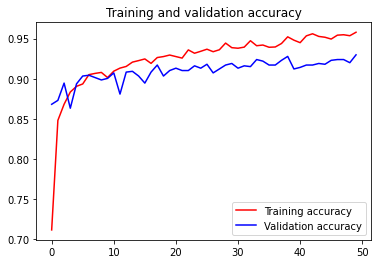

<Figure size 432x288 with 0 Axes>

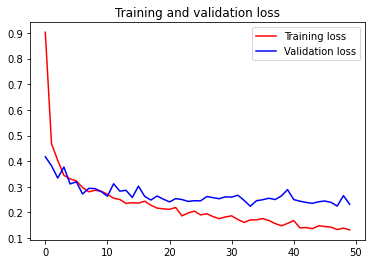

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot the training and validation accuracies and loses for each epoch

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

### Evaluate testing

In [ ]:
print("InceptionV3 Test Accuracy")
test_score = model.evaluate(testing_generator)

InceptionV3 Test Accuracy
24/24 [==============================] - 11s 476ms/step - loss: 0.2305 - accuracy: 0.9367


### Save model

In [ ]:
model.save('/content/drive/MyDrive/Bangkit Group C22-PC385/ML/SavedModels/daniel_model_inceptionv3_v5_50.h5')

## Convert into TFLite

In [ ]:
WASTON_SAVED_MODEL = "/content/drive/MyDrive/Bangkit Group C22-PC385/ML/SavedModels/daniel_waston_model_v5_50"

### Export the SavedModel

In [ ]:
tf.saved_model.save(model, WASTON_SAVED_MODEL)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Bangkit Group C22-PC385/ML/SavedModels/daniel_waston_model_v5_50/assets


In [ ]:
loaded = tf.saved_model.load(WASTON_SAVED_MODEL)

In [ ]:
print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

['serving_default']
((), {'inception_v3_input': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='inception_v3_input')})
{'dense_1': TensorSpec(shape=(None, 11), dtype=tf.float32, name='dense_1')}


Convert Using TFLite's Converter

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(WASTON_SAVED_MODEL)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

In [ ]:
tflite_model_file = '/content/drive/MyDrive/Bangkit Group C22-PC385/ML/SavedModels/converted_waston_model_v5_50.tflite'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

### Test by manually upload image

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

def upload_predict():
  uploaded = files.upload()

  for fn in uploaded.keys():
  
    # predicting images
    path = fn
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    print(fn)
    print(class_dict.get(np.argmax(classes)))

In [ ]:
upload_predict()

## Test from saved model

In [ ]:
class_dict = {0: 'battery',
              1: 'cardboard',
              2: 'clothes',
              3: 'e-waste',
              4: 'food',
              5: 'glass',
              6: 'light bulbs',
              7: 'metal',
              8: 'paper',
              9: 'plastic',
              10: 'shoes'}

In [ ]:
from tensorflow.keras.models import load_model

model_path = '/content/drive/MyDrive/Bangkit Group C22-PC385/ML/SavedModels/daniel_model_inceptionv3_v4_50.h5'
loaded_model = load_model(model_path)

### Test by manually upload image

In [ ]:
upload_predict()

Saving pile-of-electronic-scrap-at-a-junkyard-on-december-04-in-hamburg-by-picture-id454448721.jpg to pile-of-electronic-scrap-at-a-junkyard-on-december-04-in-hamburg-by-picture-id454448721.jpg
pile-of-electronic-scrap-at-a-junkyard-on-december-04-in-hamburg-by-picture-id454448721.jpg
e-waste


## Retrain model

In [11]:
from tensorflow.keras.models import load_model

model_path = '/content/drive/MyDrive/Bangkit Group C22-PC385/ML/SavedModels/daniel_model_inceptionv3_v5_50.h5'
loaded_model = load_model(model_path)

In [14]:
print("InceptionV3 Test Accuracy")
test_score = loaded_model.evaluate(testing_generator)

InceptionV3 Test Accuracy
24/24 [==============================] - 10s 423ms/step - loss: 0.2305 - accuracy: 0.9367


In [15]:
# retraining the model
EPOCHS = 50

hist = loaded_model.fit(training_generator,
                 validation_data=validation_generator,
                 steps_per_epoch=training_generator.samples // batch_size,
                 validation_steps=validation_generator.samples // batch_size,
                 workers=16,
                 epochs=EPOCHS,)

Epoch 1/50
181/181 [==============================] - 127s 655ms/step - loss: 0.1297 - accuracy: 0.9573 - val_loss: 0.2382 - val_accuracy: 0.9268
Epoch 2/50
181/181 [==============================] - 125s 656ms/step - loss: 0.1261 - accuracy: 0.9583 - val_loss: 0.2455 - val_accuracy: 0.9219
Epoch 3/50
181/181 [==============================] - 123s 648ms/step - loss: 0.1308 - accuracy: 0.9543 - val_loss: 0.2456 - val_accuracy: 0.9277
Epoch 4/50
181/181 [==============================] - 125s 655ms/step - loss: 0.1346 - accuracy: 0.9519 - val_loss: 0.2250 - val_accuracy: 0.9277
Epoch 5/50
181/181 [==============================] - 123s 640ms/step - loss: 0.1293 - accuracy: 0.9526 - val_loss: 0.2556 - val_accuracy: 0.9209
Epoch 6/50
181/181 [==============================] - 124s 648ms/step - loss: 0.1221 - accuracy: 0.9600 - val_loss: 0.2284 - val_accuracy: 0.9287
Epoch 7/50
181/181 [==============================] - 125s 659ms/step - loss: 0.1279 - accuracy: 0.9569 - val_loss: 0.2040 -

### Plot accuracy and loss

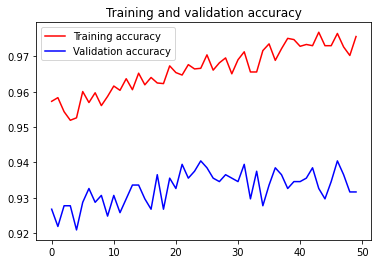

<Figure size 432x288 with 0 Axes>

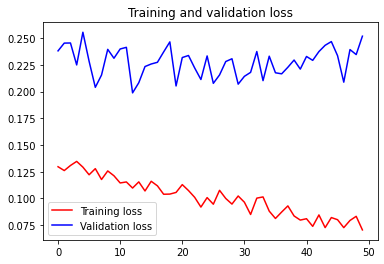

<Figure size 432x288 with 0 Axes>

In [16]:
# Plot the training and validation accuracies and loses for each epoch

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

### Evaluate testing

In [17]:
print("InceptionV3 Test Accuracy")
test_score = loaded_model.evaluate(testing_generator)

InceptionV3 Test Accuracy
24/24 [==============================] - 10s 414ms/step - loss: 0.2565 - accuracy: 0.9367


#### Test by manually upload image

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

def upload_predict():
  uploaded = files.upload()

  for fn in uploaded.keys():
  
    # predicting images
    path = fn
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    print(fn)
    print(class_dict.get(np.argmax(classes)))

In [ ]:
upload_predict()

### Save model

In [18]:
loaded_model.save('/content/drive/MyDrive/Bangkit Group C22-PC385/ML/SavedModels/daniel_model_inceptionv3_v5_50_50.h5')

### Convert into TFLite

In [19]:
WASTON_SAVED_MODEL = "/content/drive/MyDrive/Bangkit Group C22-PC385/ML/SavedModels/daniel_waston_model_v5_50_50"

#### Export the SavedModel

In [20]:
tf.saved_model.save(loaded_model, WASTON_SAVED_MODEL)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Bangkit Group C22-PC385/ML/SavedModels/daniel_waston_model_v5_50_50/assets


In [21]:
loaded = tf.saved_model.load(WASTON_SAVED_MODEL)

In [22]:
print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

['serving_default']
((), {'inception_v3_input': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='inception_v3_input')})
{'dense_1': TensorSpec(shape=(None, 11), dtype=tf.float32, name='dense_1')}


Convert Using TFLite's Converter

In [23]:
converter = tf.lite.TFLiteConverter.from_saved_model(WASTON_SAVED_MODEL)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

In [24]:
tflite_model_file = '/content/drive/MyDrive/Bangkit Group C22-PC385/ML/SavedModels/converted_waston_model_v5_50_50.tflite'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

### Test from saved model

In [ ]:
class_dict = {0: 'battery',
              1: 'cardboard',
              2: 'clothes',
              3: 'e-waste',
              4: 'food',
              5: 'glass',
              6: 'light bulbs',
              7: 'metal',
              8: 'paper',
              9: 'plastic',
              10: 'shoes'}

In [ ]:
from tensorflow.keras.models import load_model

model_path = '/content/drive/MyDrive/Bangkit Group C22-PC385/ML/SavedModels/daniel_model_inceptionv3_v5_50_50.h5'
loaded_model = load_model(model_path)

#### Test by manually upload image

In [ ]:
upload_predict()

Saving pile-of-electronic-scrap-at-a-junkyard-on-december-04-in-hamburg-by-picture-id454448721.jpg to pile-of-electronic-scrap-at-a-junkyard-on-december-04-in-hamburg-by-picture-id454448721.jpg
pile-of-electronic-scrap-at-a-junkyard-on-december-04-in-hamburg-by-picture-id454448721.jpg
e-waste
